# Global SST - RYF

In [1]:
RUNS = {
    "b_grid": '/g/data/tm70/as2285/MOM6-CICE6-b_grid',  # (our name: run name(s))
    "c_grid": '/g/data/tm70/as2285/MOM6-CICE6-c_grid',
}

In [2]:
VARS = ["tos", "sos" ]  #sea surface temperature, and sea surface salinity

In [3]:
from intake import open_esm_datastore
import xarray as xr
import cf_xarray
import matplotlib.pyplot as plt
from datatree import DataTree, map_over_subtree

from dask.distributed import Client

In [4]:
client = Client(threads_per_worker=1)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 15.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38057,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 15.00 GiB
Comm: tcp://127.0.0.1:41875,Total threads: 1
Dashboard: /proxy/44667/status,Memory: 3.75 GiB
Nanny: tcp://127.0.0.1:35661,


In [5]:
ds = open_esm_datastore(
            RUNS['b_grid'] + '/intake_datastore.json',
            columns_with_iterables=["variable"] 
        )

In [6]:
def open_by_path(path, vars):
    """Return a dataset for the requested name and vars"""
    ds = open_esm_datastore(
            path + '/intake_datastore.json',
            columns_with_iterables=["variable"] 
        )
        
    mom_xr = ds.search(variable=vars,frequency="1mon").to_dask()

    areacello = ds.search(variable='areacello')

    areacello = areacello.search(path=areacello.df.path[0]).to_dask().set_coords('areacello').drop_vars('time')

    
    
    return mom_xr.merge(areacello)

Make a datatree containing the requested vars and the requested experiments

In [7]:
name_ds_pairs = [(iRun, open_by_path(RUNS[iRun], VARS)) for iRun in RUNS.keys()]

In [8]:
sfc_dt = DataTree.from_dict(dict(name_ds_pairs))

In [9]:
sfc_dt['b_grid'].sos

<xarray.DataArray 'sos' (time: 480, yh: 300, xh: 360)> Size: 207MB
dask.array<concatenate, shape=(480, 300, 360), dtype=float32, chunksize=(1, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 4kB 1900-01-16 12:00:00 ... 1939-12-16 12:00:00
  * yh         (yh) float64 2kB -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * xh         (xh) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
    areacello  (yh, xh) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
Attributes:
    units:          psu
    long_name:      Sea Surface Salinity
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_salinity

In [10]:
@map_over_subtree
def global_mean(ds):
    return (ds*ds.areacello).cf.sum(['X','Y'])/(ds.areacello.cf.sum(['X','Y']))

In [11]:
sfc_glob_dt = global_mean(sfc_dt)

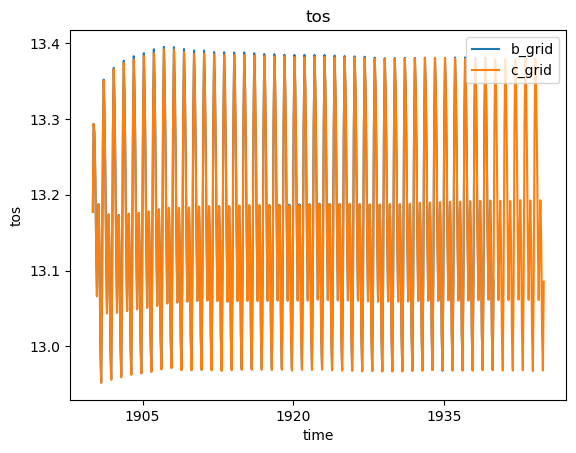

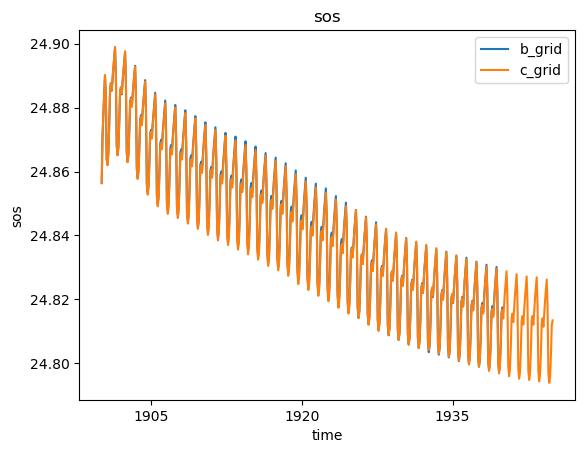

In [12]:
for iVar in VARS:
    plt.figure()
    
    for iGroup in sfc_glob_dt.groups[1:]:
        sfc_glob_dt[iGroup].ds[iVar].plot(label=iGroup[1:])

    plt.title(iVar)
    _ = plt.legend()
    

In [13]:
@map_over_subtree
def year_min(ds):
    return ds.groupby('time.year').min()

@map_over_subtree
def year_max(ds):
    return ds.groupby('time.year').max()

In [14]:
min_sfc_global_dt = year_min(sfc_glob_dt)
max_sfc_global_dt = year_max(sfc_glob_dt)

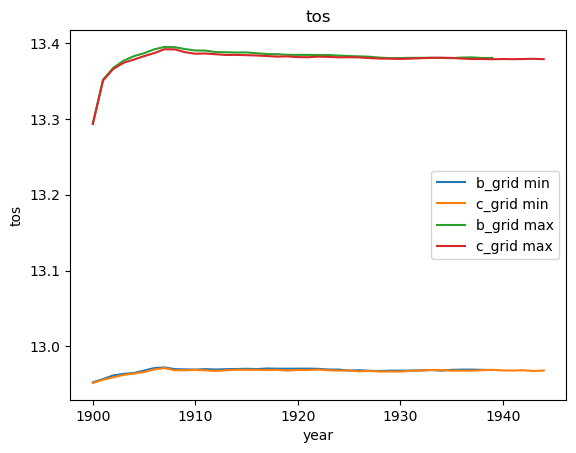

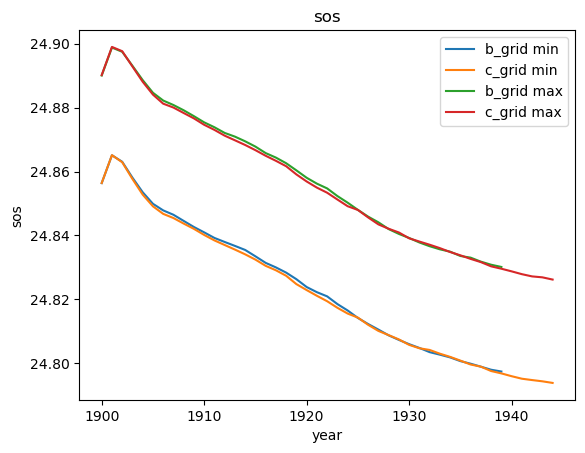

In [15]:
for iVar in VARS:
    plt.figure()

    for iGroup in min_sfc_global_dt.groups[1:]:
        min_sfc_global_dt[iGroup].ds[iVar].plot(label=iGroup[1:]+' min')
    
    for iGroup in max_sfc_global_dt.groups[1:]:
        max_sfc_global_dt[iGroup].ds[iVar].plot(label=iGroup[1:]+' max')

    plt.title(iVar)
    _ = plt.legend()
    

In [16]:
VARS_GLOB = ['thetaoga', 'soga']

In [17]:
name_ds_pairs = [(iRun, open_by_path(RUNS[iRun], VARS_GLOB)) for iRun in RUNS.keys()]

In [18]:
ocn_glob_dt = DataTree.from_dict(dict(name_ds_pairs))

In [19]:
min_global_dt = year_min(ocn_glob_dt)
max_global_dt = year_max(ocn_glob_dt)

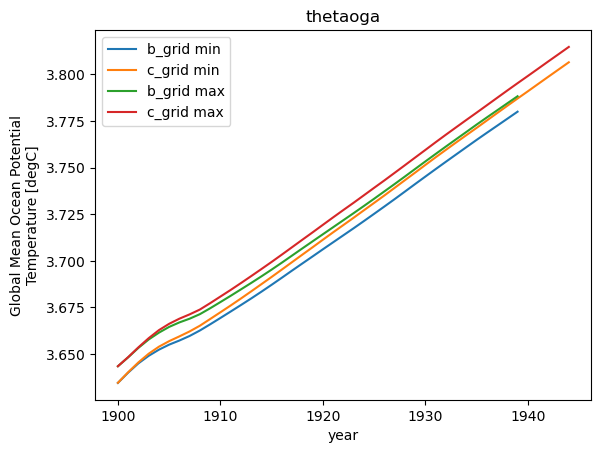

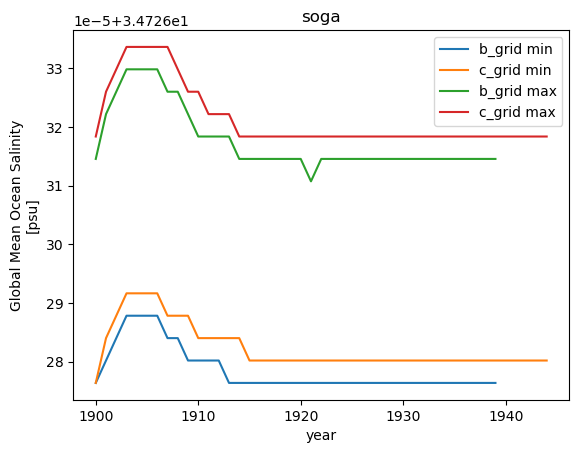

In [20]:
for iVar in VARS_GLOB:
    plt.figure()

    for iGroup in min_global_dt.groups[1:]:
        min_global_dt[iGroup].ds[iVar].plot(label=iGroup[1:]+' min')
    
    for iGroup in max_global_dt.groups[1:]:
        max_global_dt[iGroup].ds[iVar].plot(label=iGroup[1:]+' max')

    plt.title(iVar)
    _ = plt.legend()
    